In [1]:
import Simulation
import US_State

## Download geometry and OD information for a US State

In [2]:
fips=44
year=2017
geom_type='block'
centre= {'lat': 41.825407,  'lon': -71.411801}
centre_x_y=[centre['lon'], centre['lat']]

model_area_radius=3000
sim_area_radius=1000

state=US_State.US_State(state_fips=fips, year=year, 
#                         geom_type=geom_type
                       )
state.get_geometry()

Getting geometry (block_group) for state: Rhode Island


/Volumes/GoogleDrive/My Drive/Media Lab/NuevoScope/CS_Spatial_Modules/US_State.py:54: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids=self.geom['geometry'].centroid


## Specify which zones are in (i) the model area (full study area) and (ii) the simulation area (bounds of the table)

In [3]:
state.subset_geom_by_distance(centre_x_y, model_area_radius, 'model_area')
state.subset_geom_by_distance(centre_x_y, sim_area_radius, 'sim_area')

	 Subsetting zones by distance
	 Subsetting zones by distance


In [4]:
all_zones=state.return_geometry()
sim_zones=state.return_geometry('sim_area')
model_zones=state.return_geometry('model_area')

In [5]:
sim_geoids=sim_zones.index

In [6]:
len(sim_geoids)

6

## Simulate a population based on the OD matrix
### Sim Pop will only include individuals who satisfy both of these conditions:
- live AND work in the model area
- live OR work in the sim area. 

In [7]:
state.get_lodes_data()
simpop_df=state.lodes_to_pop_table(model_subset_name='model_area',
                                  sim_subset_name='sim_area')

Getting WAC data from https://lehd.ces.census.gov/data/lodes/LODES7/
	 Formatting WAC data
Getting RAC data from https://lehd.ces.census.gov/data/lodes/LODES7/
	 Formatting RAC data
Getting OD data from https://lehd.ces.census.gov/data/lodes/LODES7/
	 Formatting OD data
Using 538 of 152609 rows in OD data
0 of 538


## Create a pandana network for each mode

In [8]:
import pandana
import osmnet

networks={}

bbox=state.get_bounds(subset_name='model_area')
drive_nodes_df,drive_edges_df=osmnet.load.network_from_bbox(lat_min=bbox[1], lng_min=bbox[0], lat_max=bbox[3], 
                          lng_max=bbox[2], bbox=None, network_type='drive', 
                          two_way=True, timeout=180, 
                          custom_osm_filter=None)
drive_edges_df['travel_time']=drive_edges_df['distance']*50000/3600

drive_net=pandana.Network(drive_nodes_df["x"], drive_nodes_df["y"], drive_edges_df["from"], drive_edges_df["to"],
                 drive_edges_df[["distance", "travel_time"]])

networks['drive']=Simulation.PdnaNetwork(drive_net)

/Users/doorleyr/anaconda3/envs/pandana/lib/python3.9/site-packages/osmnet/load.py:445: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf.crs = crs
/Users/doorleyr/anaconda3/envs/pandana/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Requesting network data within bounding box from Overpass API in 1 request(s)
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"cycleway|footway|path|pedestrian|steps|track|proposed|construction|bridleway|abandoned|platform|raceway|service"]["motor_vehicle"!~"no"]["motorcar"!~"no"]["service"!~"parking|parking_aisle|driveway|emergency_access"](41.79640267,-71.44974543,41.85682780,-71.37309955);>;);out;'}"
Downloaded 2,858.0KB from www.overpass-api.de in 1.48 seconds
Downloaded OSM network data within bounding box from Overpass API in 1 request(s) and 1.53 seconds
Returning OSM data with 19,690 nodes and 3,095 ways...
Edge node pairs completed. Took 3.89 seconds
Returning processed graph with 4,252 nodes and 6,453 edges...
Completed OSM data download and Pandana node and edge table creation in 6.08 seconds
building link attribute lookup


In [9]:
drive_dict={
    'target_network_id': 'drive',
    'travel_time_metric': 'travel_time'}


modes={'drive': Simulation.Mode(drive_dict), 
#        'walk': OpenCity.Mode(walk_dict)
      }

mob_sys=Simulation.MobilitySystem(modes=modes, networks= networks)

# Create the Simulation

In [10]:
sim=Simulation.Simulation(simpop_df, mob_sys, model_zones, sim_geoids=sim_geoids)
simpop_df=sim.get_simpop_subset(simpop_df, sample_N=1000)
simpop_df=sim.create_simple_HWH_schedules(simpop_df)
all_trips_df=sim.create_trip_table(simpop_df)
all_trips_df=sim.mode_chooser.predict_modes(all_trips_df)
route_table=sim.get_routes_table(all_trips_df)
route_gdf=sim.route_table_to_geo(route_table)

Getting internal nodes


/Users/doorleyr/anaconda3/envs/pandana/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


Finding closest nodes to every zone centroid


/Volumes/GoogleDrive/My Drive/Media Lab/NuevoScope/CS_Spatial_Modules/Simulation.py:405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  route_table_this_mode['node_path']=routes['node_path']
/Volumes/GoogleDrive/My Drive/Media Lab/NuevoScope/CS_Spatial_Modules/Simulation.py:406: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  route_table_this_mode['attributes']=routes['attributes']


## Plot Trajectories by demographic attribute (Income level)

<AxesSubplot:>

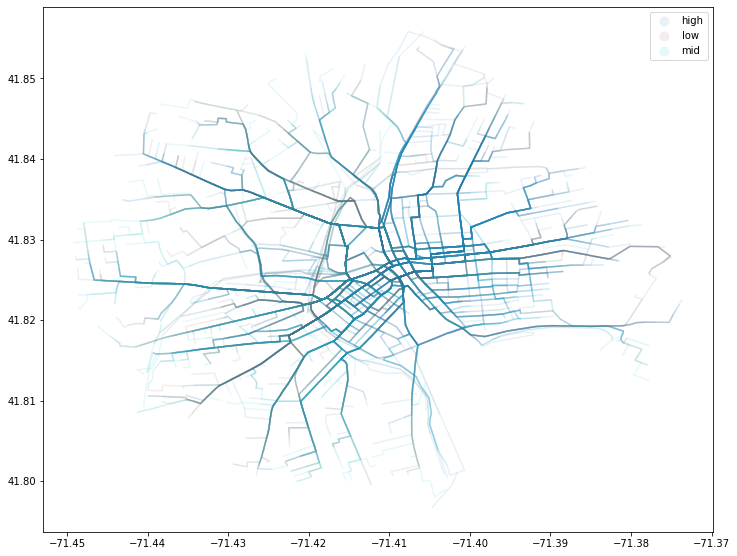

In [11]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, figsize=(12,12))
route_gdf.plot(column='earnings', legend=True, alpha=0.1, ax=ax)